# About
- Sale analysis on a Favorita stores located in Ecuador
- creating a Forecasting pipepipe for future sales

In [2]:
# libary requirement
import numpy as np
import pandas as pd
import pandasql as ps
import math
import itertools 

#matplotlib libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
import seaborn as sns

#date libraries
from dateutil import parser
from datetime import datetime, timedelta, date
import holidays

#prophet library
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation

#pandas options
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#matplotlib setting defaults
sns.set(font="Arial",
        rc={
 "axes.axisbelow": False,
 "axes.edgecolor": "lightgrey",
 "axes.facecolor": "None",
 "axes.grid": False,
 "axes.labelcolor": "dimgrey",
 "axes.spines.right": False,
 "axes.spines.top": False,
 "figure.facecolor": "white",
 "lines.solid_capstyle": "round",
 "patch.edgecolor": "w",
 "patch.force_edgecolor": True,
 "text.color": "dimgrey",
 "xtick.bottom": False,
 "xtick.color": "dimgrey",
 "xtick.direction": "out",
 "xtick.top": False,
 "ytick.color": "dimgrey",
 "ytick.direction": "out",
 "ytick.left": False,
 "ytick.right": False})

In [5]:
#pip install prophet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 1.7 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 759.7/759.7 kB 2.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 1.2 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: holidays
    Found existing installation: holidays 0.21
    Uninstalling holidays-0.21:
      Successfully uninstalled holidays-0.21
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 1.1.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [14]:
def missing_data(input_data):
    '''
    This function returns dataframe with information about the percentage of nulls in each column and the column data type.
    
    input: pandas df
    output: pandas df
    
    '''
    
    total = input_data.isnull().sum()
    percent = (input_data.isnull().sum()/input_data.isnull().count()*100)
    table = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
    types = []
    for col in input_data.columns: 
        dtype = str(input_data[col].dtype)
        types.append(dtype)
    table["Types"] = types
    return(pd.DataFrame(table))


In [56]:
missing_data(df)

,Total,Percent,Types
id,0,0.00,int64
date,0,0.00,object
store_nbr,0,0.00,int64
family,0,0.00,object
sales,0,0.00,float64
onpromotion,0,0.00,int64


In [55]:
df = pd.read_csv('/Users/mac/Downloads/train.csv')
df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.00,0
1,1,2013-01-01,1,BABY CARE,0.00,0
2,2,2013-01-01,1,BEAUTY,0.00,0
3,3,2013-01-01,1,BEVERAGES,0.00,0
4,4,2013-01-01,1,BOOKS,0.00,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [10]:
df['date'] = pd.to_datetime(df['date'], format= "%Y/%m/%d")

In [11]:
min(df['date']), max(df['date'])

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-15 00:00:00'))

In [57]:
df.describe()

,id,store_nbr,sales,onpromotion
count,3000888.00,3000888.00,3000888.00,3000888.00
mean,1500443.50,27.50,357.78,2.60
std,866281.89,15.59,1102.00,12.22
min,0.00,1.00,0.00,0.00
25%,750221.75,14.00,0.00,0.00
50%,1500443.50,27.50,11.00,0.00
75%,2250665.25,41.00,195.85,0.00
max,3000887.00,54.00,124717.00,741.00


In [16]:
df['family'].unique()


array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

# Let's aggregate the dataset to the "family" and "sales" daily level so that we can have high volume metrics for demand forecasting throughout the country. 

In [17]:
agg_df = df.groupby(['date','family']).agg({'sales':'sum'}).reset_index().sort_values(['family','date'])
agg_df.head()

,date,family,sales
0,2013-01-01,AUTOMOTIVE,0.00
33,2013-01-02,AUTOMOTIVE,255.00
66,2013-01-03,AUTOMOTIVE,161.00
99,2013-01-04,AUTOMOTIVE,169.00
132,2013-01-05,AUTOMOTIVE,342.00


# Total sales columns

In [18]:
Totalsales = agg_df.pivot(index='date',columns='family',values='sales')
Totalsales.head()

family,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,EGGS,FROZEN FOODS,GROCERY I,GROCERY II,HARDWARE,HOME AND KITCHEN I,HOME AND KITCHEN II,HOME APPLIANCES,HOME CARE,LADIESWEAR,LAWN AND GARDEN,LINGERIE,"LIQUOR,WINE,BEER",MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.00,0.00,2.00,810.00,0.00,180.59,0.00,186.00,143.00,71.09,46.00,29.65,700.00,15.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,5.00,105.00,0.00,110.80,25.00,0.00,0.00,42.64,37.85,0.00,0.00,0.00
2013-01-02,255.00,0.00,207.00,72092.00,0.00,26246.32,0.00,74629.00,23381.00,15754.50,10932.00,7115.39,202020.00,1476.00,46.00,0.00,0.00,21.00,0.00,0.00,121.00,469.00,2411.00,0.00,20871.46,17204.00,0.00,0.00,13975.88,5338.11,0.00,0.00,1526.75
2013-01-03,161.00,0.00,125.00,52105.00,0.00,18456.48,0.00,55893.00,18001.00,11172.45,7358.00,4760.81,144878.00,1048.00,37.00,0.00,0.00,15.00,0.00,0.00,83.00,366.00,2476.00,0.00,16597.40,12568.00,0.00,0.00,10674.39,3591.39,0.00,0.00,1094.31
2013-01-04,169.00,0.00,133.00,54167.00,0.00,16721.97,0.00,52064.00,18148.00,10143.21,6760.00,4525.93,135754.00,1031.00,57.00,0.00,0.00,13.00,0.00,0.00,127.00,382.00,4796.00,0.00,21625.96,11303.00,0.00,0.00,10772.52,4472.97,0.00,0.00,1293.12
2013-01-05,342.00,0.00,191.00,77818.00,0.00,22367.76,0.00,70128.00,23082.00,13734.95,8576.00,5781.61,188356.00,1273.00,87.00,0.00,0.00,11.00,0.00,0.00,180.00,458.00,6715.00,0.00,20879.09,16819.00,0.00,0.00,13475.01,5830.07,0.00,0.00,1245.64


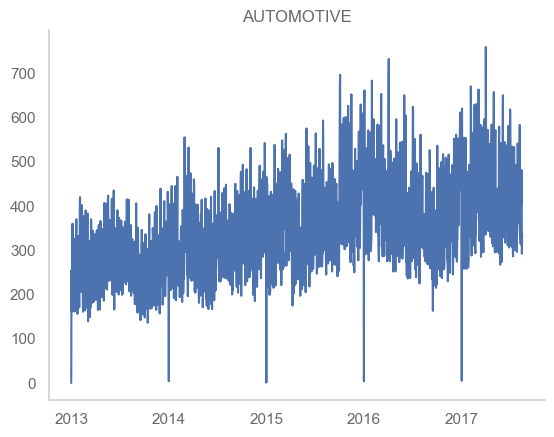

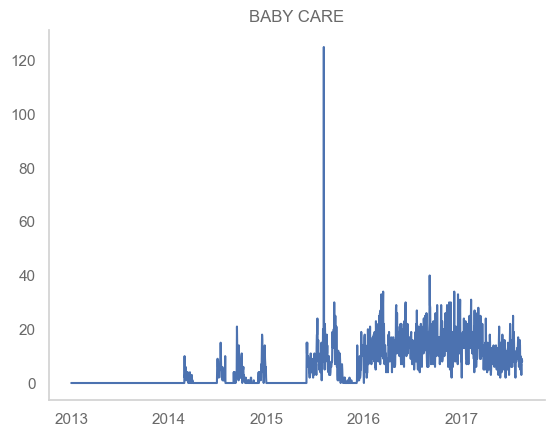

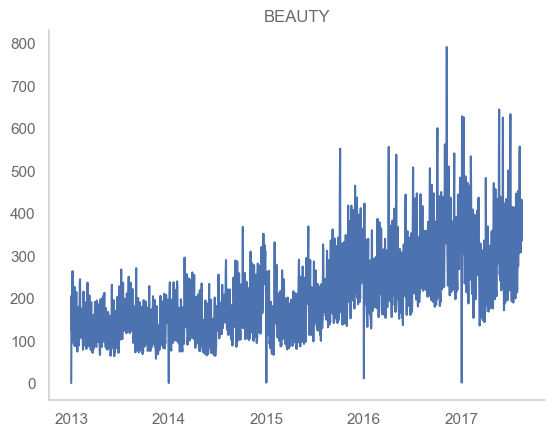

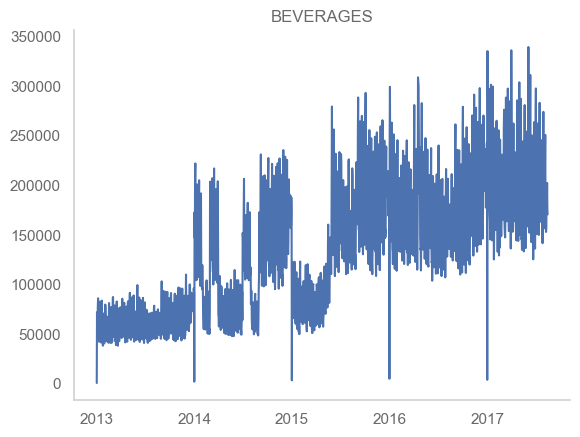

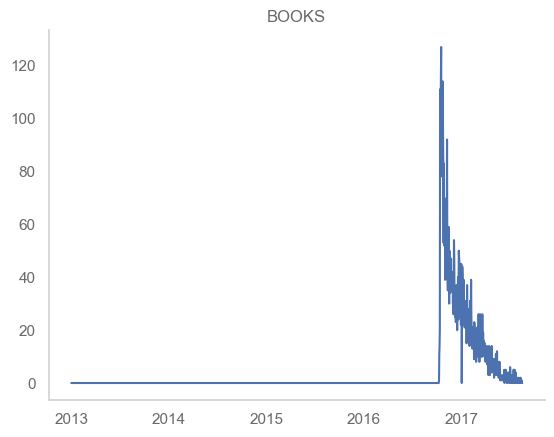

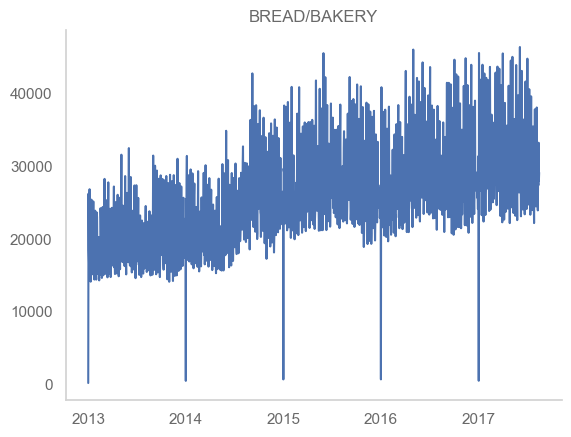

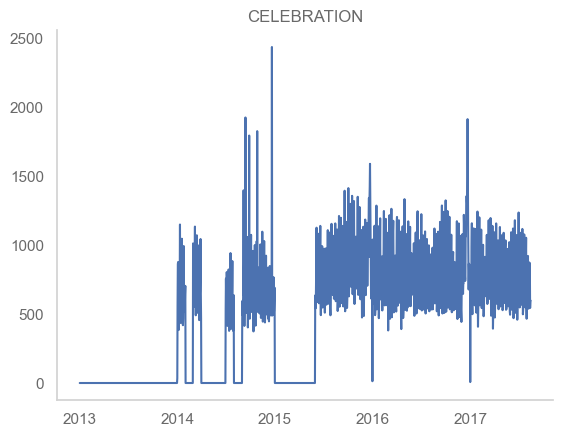

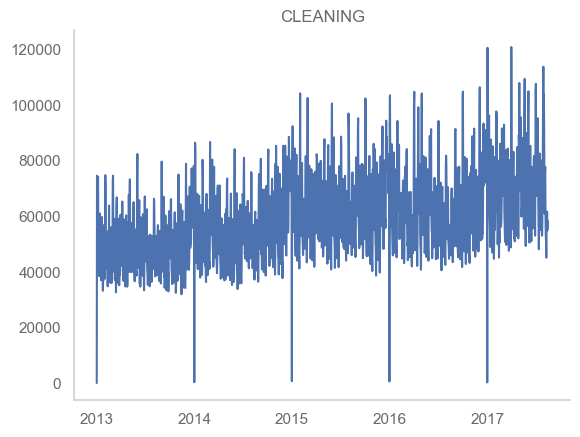

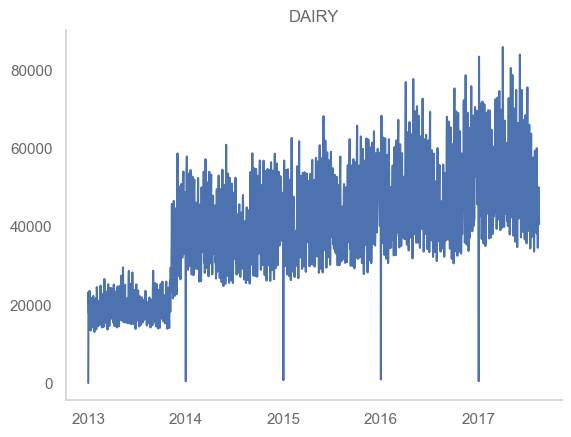

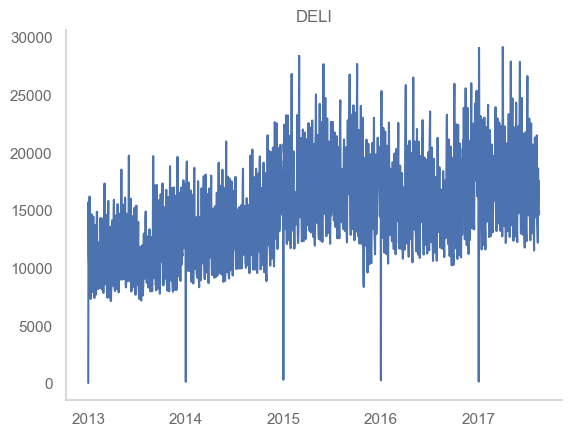

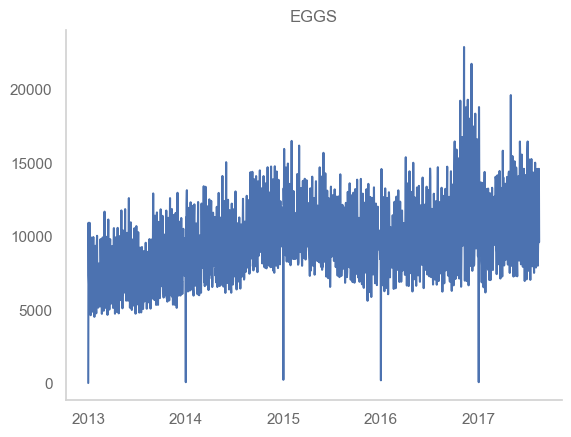

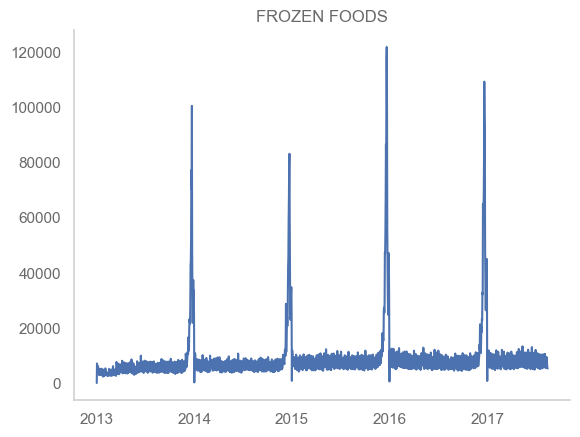

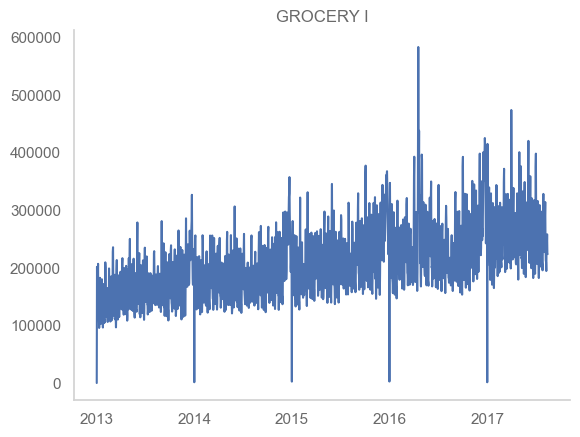

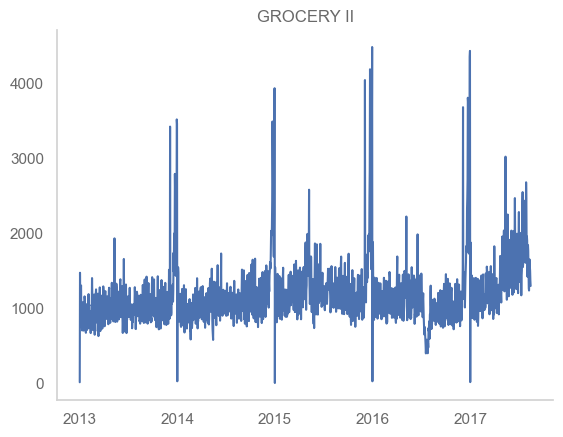

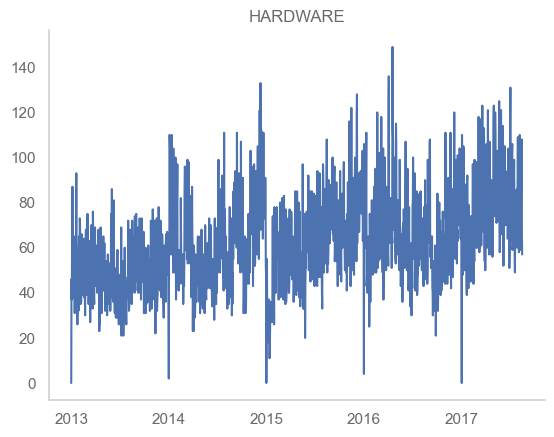

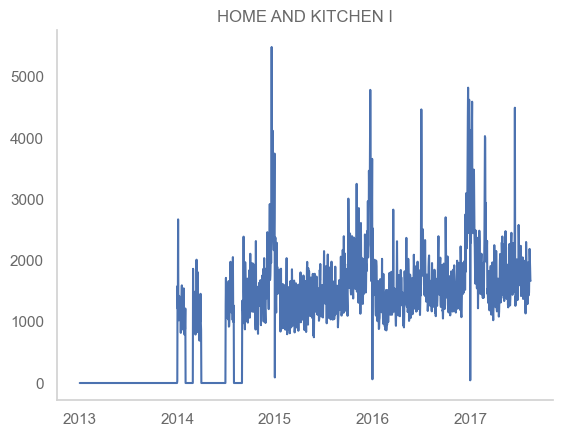

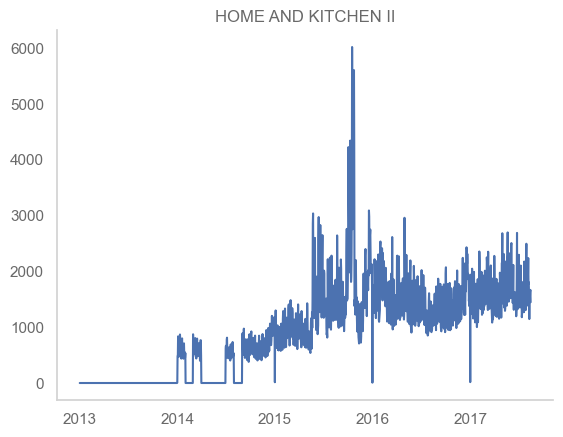

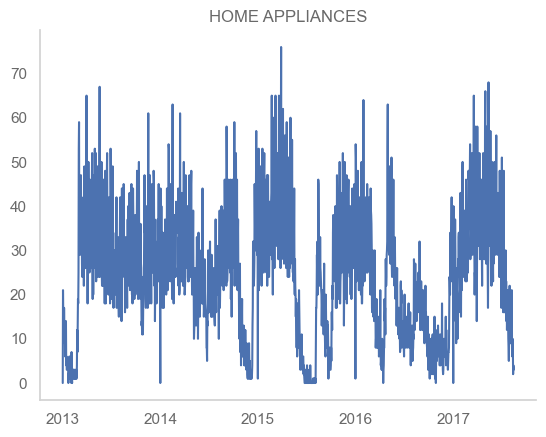

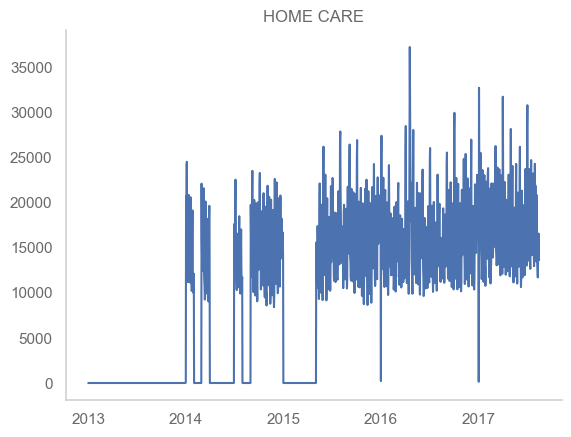

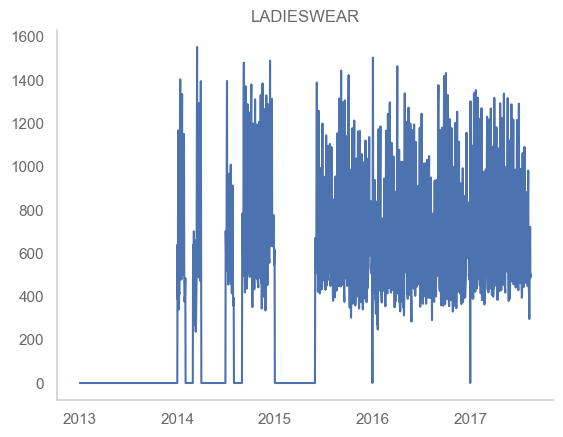

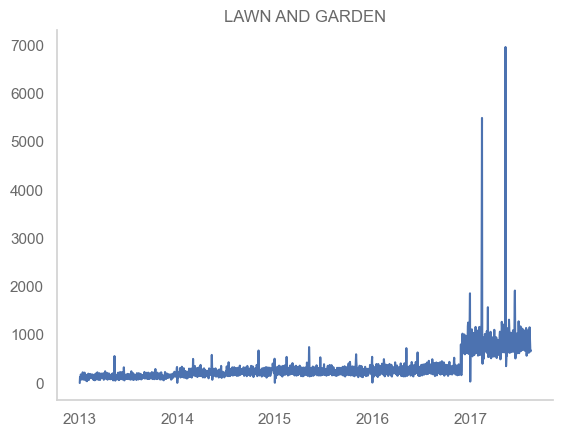

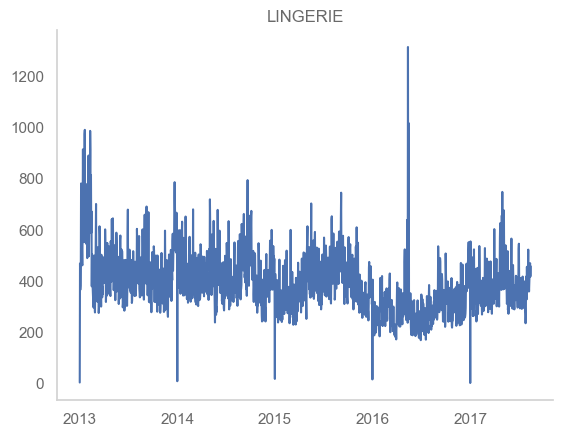

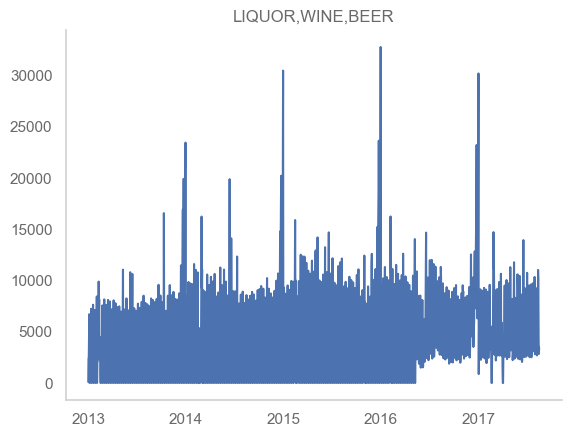

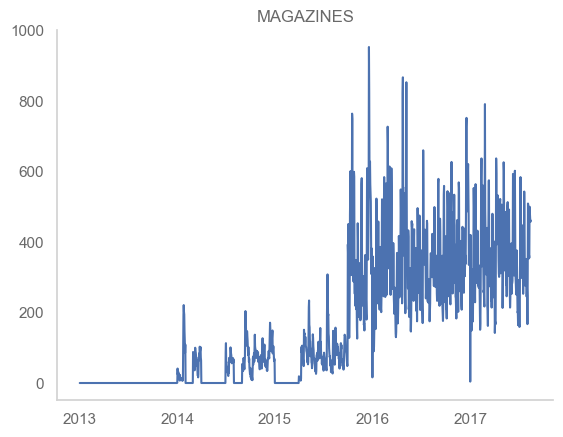

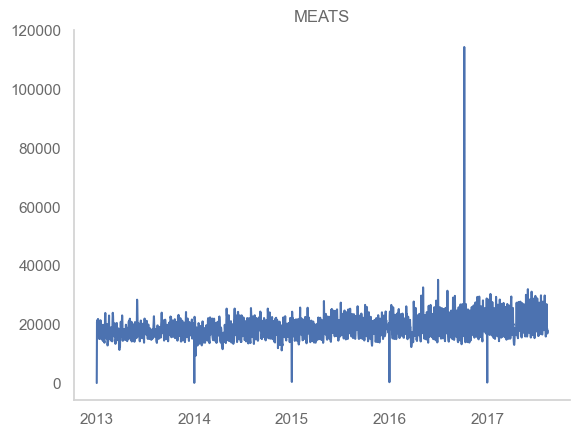

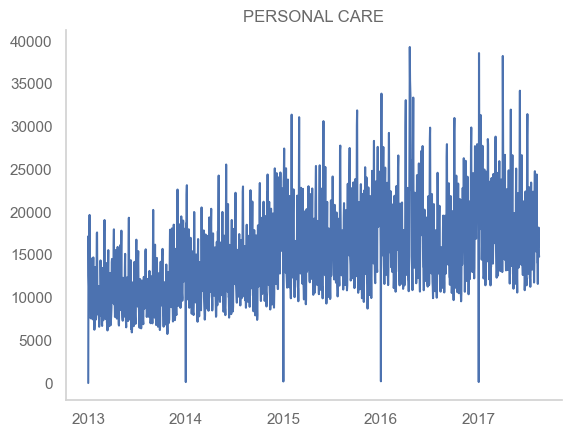

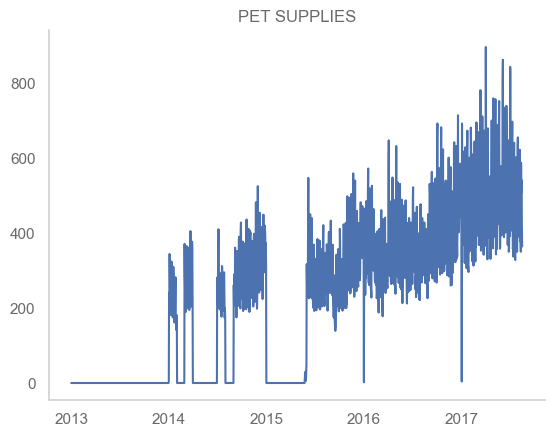

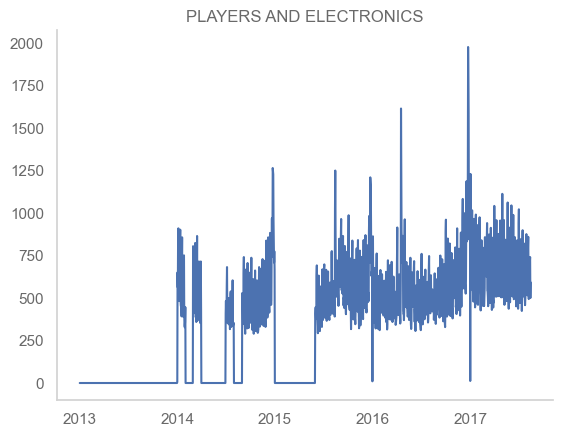

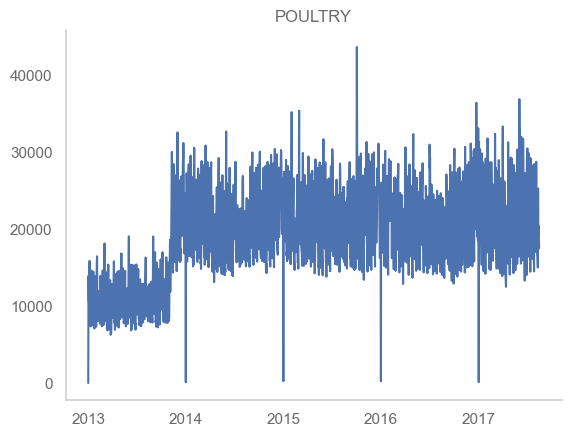

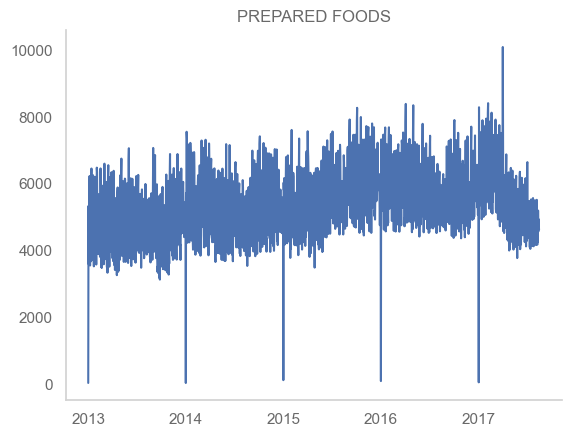

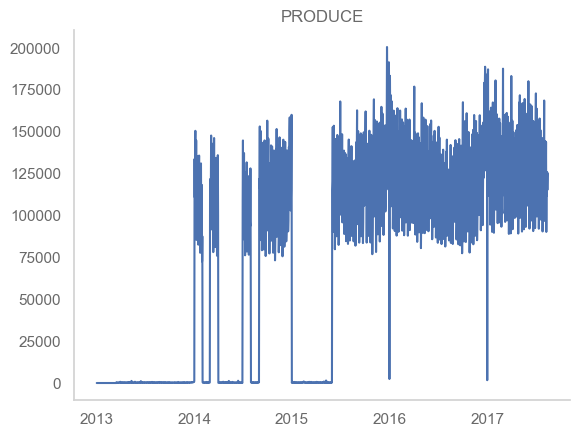

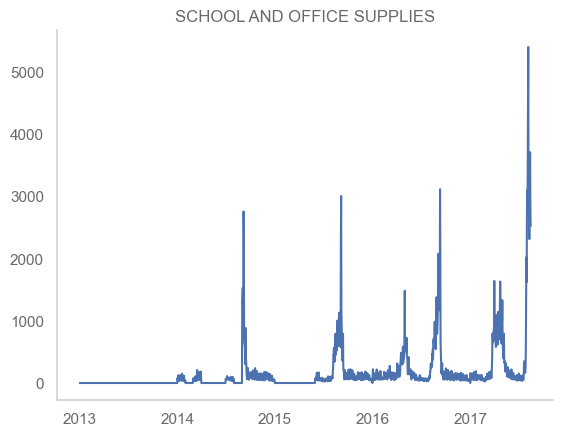

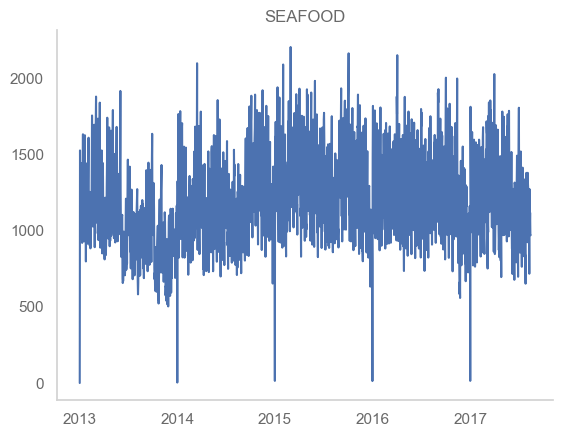

In [19]:
for col in Totalsales.columns:
    plt.plot(Totalsales[col])
    plt.title(col)
    plt.show()

# Getting data for 2015 because older data are not Seasonal  and can cause noise when forecasting

In [20]:
Totalsales = Totalsales[Totalsales.index>= '2015-08-15']
Totalsales.head()

family,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,EGGS,FROZEN FOODS,GROCERY I,GROCERY II,HARDWARE,HOME AND KITCHEN I,HOME AND KITCHEN II,HOME APPLIANCES,HOME CARE,LADIESWEAR,LAWN AND GARDEN,LINGERIE,"LIQUOR,WINE,BEER",MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-08-15,454.00,18.00,251.00,217135.00,0.00,32509.91,1157.00,75837.00,48578.00,19946.92,11232.00,10075.02,280491.48,1552.00,108.00,1899.00,1526.00,46.00,18924.00,879.00,268.00,525.00,9423.00,153.00,20403.94,19398.00,370.00,1250.00,24718.80,6854.54,128147.18,701.00,1507.24
2015-08-16,413.00,11.00,313.00,208213.00,0.00,34851.88,724.00,75824.00,50930.00,21178.46,11977.00,7526.03,266657.28,1441.00,62.00,1418.00,1850.00,45.00,19757.00,955.00,220.00,530.00,0.00,157.00,20616.16,21048.00,359.00,913.00,25480.78,6640.39,131493.93,793.00,1448.72
2015-08-17,289.00,14.00,175.00,149741.00,0.00,26361.77,593.00,59718.00,38358.00,15755.02,10713.00,5145.30,205150.61,1161.00,49.00,1143.00,1343.00,36.00,14120.00,564.00,154.00,480.00,2968.00,125.00,16725.03,14854.00,263.00,593.00,18549.11,5212.50,102769.60,458.00,1166.22
2015-08-18,295.00,10.00,166.00,132609.00,0.00,23915.95,709.00,52749.00,33273.00,14119.25,8123.00,5050.99,181016.01,955.00,69.00,1181.00,1320.00,31.00,12202.00,485.00,187.00,376.00,2984.00,102.00,15377.12,13064.00,193.00,519.00,15722.33,4758.13,106468.23,494.00,951.63
2015-08-19,314.00,5.00,176.00,131368.00,0.00,23995.15,599.00,51157.00,35760.00,13250.04,8001.00,5372.18,178550.63,1011.00,55.00,1132.00,1249.00,27.00,12042.00,492.00,264.00,371.00,3786.00,102.00,15654.35,12581.00,257.00,535.00,16360.62,5275.08,132449.58,545.00,996.73


- Let's group these different categories by the volume of data. The higher volume data the better for forecasting since you can forecast past the noise and end up with lower error bars. This will also let us visualize the forecasts on similar scales so that we can figure out if timeseries modeling will work for the categories since timeseries highly depends on seasonal data of a certain variation (addtitive, multiplicative).

In [21]:
#lets break it down by thirds for low, mid, high
avg_daily_sales = Totalsales.apply(np.mean, axis=0).sort_values()
low, mid = np.percentile(Totalsales.apply(np.mean, axis=0).sort_values(),[33,66])

In [22]:
low_vol_columns = list(avg_daily_sales[avg_daily_sales<=low].index)
mid_vol_columns = avg_daily_sales[(avg_daily_sales>low) & (avg_daily_sales<mid)].index
high_vol_columns = avg_daily_sales[avg_daily_sales>=mid].index

In [23]:
low_vol_columns

['BOOKS',
 'BABY CARE',
 'HOME APPLIANCES',
 'HARDWARE',
 'BEAUTY',
 'SCHOOL AND OFFICE SUPPLIES',
 'MAGAZINES',
 'LINGERIE',
 'PET SUPPLIES',
 'AUTOMOTIVE',
 'LAWN AND GARDEN']

In [24]:
high_vol_columns

Index(['HOME CARE', 'DELI', 'PERSONAL CARE', 'MEATS', 'POULTRY',
       'BREAD/BAKERY', 'DAIRY', 'CLEANING', 'PRODUCE', 'BEVERAGES',
       'GROCERY I'],
      dtype='object', name='family')

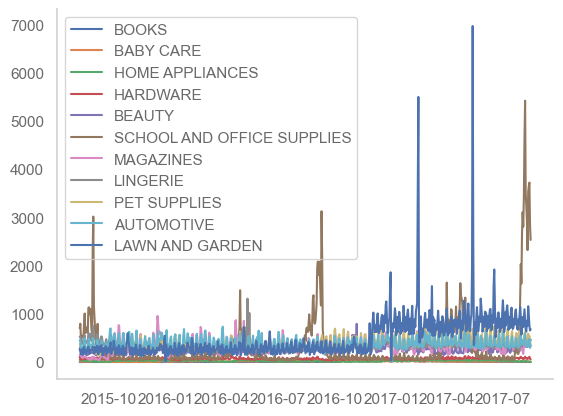

In [25]:
#total_sales_df[low_vol_columns].plot.line()
plt.plot(Totalsales[low_vol_columns])
plt.legend(low_vol_columns, loc='best') #, bbox_to_anchor=(1.1, 1.1))
plt.show()

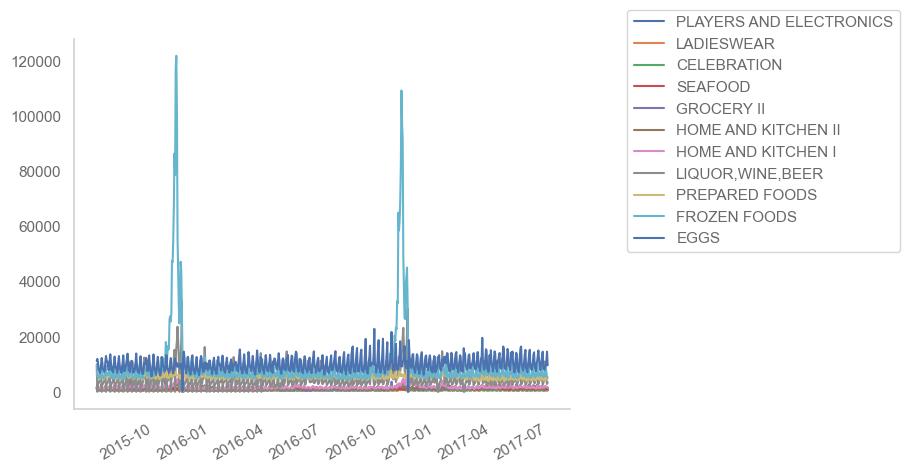

In [26]:
plt.plot(Totalsales[mid_vol_columns])
plt.legend(mid_vol_columns, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.xticks(rotation=30)
plt.show()

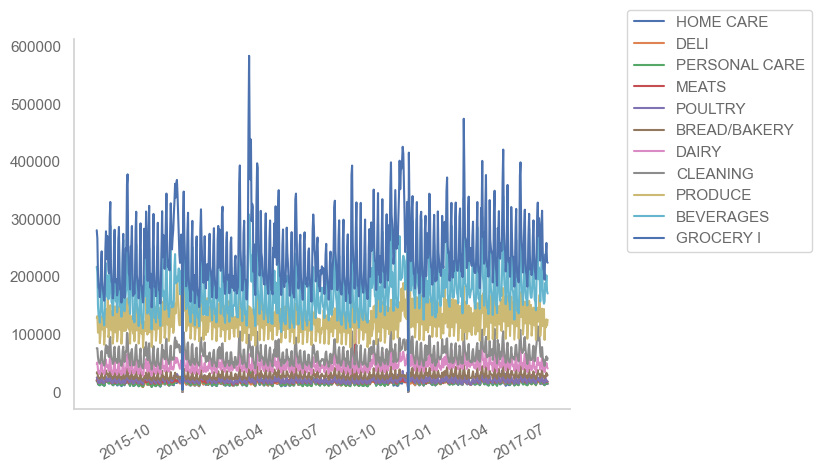

In [27]:
plt.plot(Totalsales[high_vol_columns])
plt.legend(high_vol_columns, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.xticks(rotation=30)
plt.show()

- Let's test things out with a high volume metric first to see if things work. Let's test with "PRODUCE."

In [28]:
#setting variables
feature = 'PRODUCE'
prediction_days = 30

In [29]:
df = Totalsales[[feature]].reset_index()
df.head()

family,date,PRODUCE
0,2015-08-15,128147.18
1,2015-08-16,131493.93
2,2015-08-17,102769.60
3,2015-08-18,106468.23
4,2015-08-19,132449.58


# Adding holiday data
- To take into condition when forecasting the holiday days in ecuador because during holidays the sale spikes and dont follows the normal trends

In [30]:
#adding holiday data
holiday = pd.DataFrame([])

ecuador_holidays = holidays.EC()  # this is a dict
# the below is the same, but takes a string:
ecuador_holidays = holidays.country_holidays('EC')  # this is a dict


for date_, name in sorted(holidays.EC(years=[2015,2016,2017,2018]).items()):
    holiday = pd.concat([holiday, pd.DataFrame({'ds': date_, 'holiday': "EC-Holidays", 'lower_window': -2, 'upper_window': 1}, index=[0])], ignore_index=True) 

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')
holiday.head()

,ds,holiday,lower_window,upper_window
0,2015-01-01,EC-Holidays,-2,1
1,2015-02-16,EC-Holidays,-2,1
2,2015-02-17,EC-Holidays,-2,1
3,2015-04-03,EC-Holidays,-2,1
4,2015-05-01,EC-Holidays,-2,1


In [6]:
pip install holidays

Note: you may need to restart the kernel to use updated packages.


In [31]:
#Variables

forecast_start_dt = date(2017,7,1) #data set ends of (2017,8,15)
forecast_start_date = (forecast_start_dt).strftime("%Y-%m-%d") 
print(forecast_start_date)

2017-07-01


In [32]:
# Prophet model
#PROPHET MODEL

df_copy = df.copy()
df_copy = df_copy.rename(columns={'date': 'ds', feature: 'y'})
df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)

df_copy['ds'] = pd.to_datetime(df_copy['ds'])

train_set = df_copy[(df_copy['ds'] < forecast_start_date) ]

m = Prophet()

m.fit(train_set)

future = m.make_future_dataframe(periods=prediction_days)
fcst_prophet_train = m.predict(future)

#adding filter to only add the forecasted data into predicted_df
filter = fcst_prophet_train['ds']>=forecast_start_date 
predicted_df = fcst_prophet_train[filter][['ds','yhat']]

16:37:31 - cmdstanpy - INFO - Chain [1] start processing
16:37:31 - cmdstanpy - INFO - Chain [1] done processing


In [33]:
predicted_df

,ds,yhat
684,2017-07-01,144612.13
685,2017-07-02,155336.04
686,2017-07-03,122383.38
687,2017-07-04,127642.39
688,2017-07-05,160253.27
689,2017-07-06,102667.68
690,2017-07-07,116017.82
691,2017-07-08,144864.32
692,2017-07-09,155588.23
693,2017-07-10,122635.58


In [37]:
df_copy = df.copy()
df_copy.columns = ['ds', 'ytrue']
predicted_df = predicted_df.merge(df_copy)
predicted_df

,ds,yhat,ytrue
0,2017-07-01,144612.13,155487.63
1,2017-07-02,155336.04,172890.14
2,2017-07-03,122383.38,130389.20
3,2017-07-04,127642.39,131534.55
4,2017-07-05,160253.27,163804.33
5,2017-07-06,102667.68,99395.60
6,2017-07-07,116017.82,114346.57
7,2017-07-08,144864.32,139294.77
8,2017-07-09,155588.23,156633.92
9,2017-07-10,122635.58,118856.99


In [38]:

def mape(actual, pred): 
    '''
    Mean Absolute Percentage Error (MAPE) Function
    
    input: list/series for actual values and predicted values
    output: mape value 
    '''
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [39]:
mape(predicted_df['ytrue'], predicted_df['yhat'])

6.263881123154167

## Cross Validation with Prophet

Find the "best" parameters by testing over various periods of time with those parameters (cross-validation).

In [40]:
m = Prophet()
m.fit(train_set)
df_cv = cross_validation(m, initial='365 days', period='30 days', horizon = '30 days')

16:42:16 - cmdstanpy - INFO - Chain [1] start processing
16:42:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/10 [00:00<?, ?it/s]

16:42:16 - cmdstanpy - INFO - Chain [1] start processing
16:42:16 - cmdstanpy - INFO - Chain [1] done processing
16:42:16 - cmdstanpy - INFO - Chain [1] start processing
16:42:16 - cmdstanpy - INFO - Chain [1] done processing
16:42:16 - cmdstanpy - INFO - Chain [1] start processing
16:42:16 - cmdstanpy - INFO - Chain [1] done processing
16:42:16 - cmdstanpy - INFO - Chain [1] start processing
16:42:16 - cmdstanpy - INFO - Chain [1] done processing
16:42:16 - cmdstanpy - INFO - Chain [1] start processing
16:42:17 - cmdstanpy - INFO - Chain [1] done processing
16:42:17 - cmdstanpy - INFO - Chain [1] start processing
16:42:17 - cmdstanpy - INFO - Chain [1] done processing
16:42:17 - cmdstanpy - INFO - Chain [1] start processing
16:42:17 - cmdstanpy - INFO - Chain [1] done processing
16:42:17 - cmdstanpy - INFO - Chain [1] start processing
16:42:17 - cmdstanpy - INFO - Chain [1] done processing
16:42:17 - cmdstanpy - INFO - Chain [1] start processing
16:42:17 - cmdstanpy - INFO - Chain [1]

In [41]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,411911254.07,20295.60,13088.62,0.09,0.07,0.10,0.80
1,4 days,269732789.34,16423.54,11119.74,0.08,0.06,0.08,0.80
2,5 days,141547986.52,11897.39,8894.95,0.07,0.06,0.07,0.87
3,6 days,126310847.91,11238.81,9216.62,0.07,0.07,0.07,0.87
4,7 days,95815198.40,9788.52,8407.64,0.07,0.07,0.07,0.93
5,8 days,75894857.93,8711.77,7674.79,0.06,0.06,0.06,0.97
6,9 days,61122646.17,7818.10,6577.46,0.05,0.04,0.05,0.97
7,10 days,48811966.91,6986.56,5387.81,0.05,0.04,0.05,0.97
8,11 days,78501674.86,8860.12,6694.00,0.05,0.04,0.05,0.93
9,12 days,83261445.28,9124.77,6699.75,0.05,0.05,0.05,0.93


In [42]:
df_p.tail()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
23,26 days,254632370.78,15957.20,12018.61,0.10,0.08,0.10,0.83
24,27 days,305198598.48,17469.93,13245.62,0.11,0.09,0.11,0.80
25,28 days,502076648.26,22407.07,15686.99,0.13,0.08,0.13,0.77
26,29 days,549411933.51,23439.54,16593.94,0.12,0.09,0.13,0.66
27,30 days,1247042864.57,35313.49,21490.91,3.01,0.12,0.19,0.63


df_p gives you the overall MAPE, but if you want to get more granular and calculate the daily differences using the mape metric. This allows you to detect issues in predicting certain time periods, which are inherent issues in the data that you may or may not be able to fix. 

In [43]:
df_cv['mape'] = (df_cv['y']-df_cv['yhat'])/(df_cv['y'])*100
df_cv['overestimate'] = df_cv['yhat'] > df_cv['y'] 

df_cv.sort_values('mape',ascending=False).head(10)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,mape,overestimate
110,2016-12-23,98435.33,83016.99,114676.02,176327.97,2016-12-02,44.17,False
116,2016-12-30,98482.55,84053.39,114715.36,175022.19,2016-12-02,43.73,False
109,2016-12-22,87944.49,71707.89,103523.25,140444.94,2016-12-02,37.38,False
119,2017-01-02,117105.88,96800.06,135523.07,184113.03,2017-01-01,36.39,False
120,2017-01-03,121366.40,101535.42,139226.98,183306.23,2017-01-01,33.79,False
111,2016-12-24,127831.67,112727.42,143455.15,188809.16,2016-12-02,32.30,False
117,2016-12-31,127878.90,112372.13,143085.21,184154.67,2016-12-02,30.56,False
115,2016-12-29,87991.72,72139.71,104187.65,126652.84,2016-12-02,30.53,False
238,2017-05-01,126201.34,107286.32,145099.52,167558.58,2017-04-01,24.68,False
108,2016-12-21,143735.72,127732.38,159329.32,179251.71,2016-12-02,19.81,False


lets hypertune this model!

In [44]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = [] 

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train_set)  # Fit model with given params
    df_cv = cross_validation(m, initial='365 days', period='30 days', horizon = '30 days', parallel='processes')
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses

16:48:42 - cmdstanpy - INFO - Chain [1] start processing
16:48:42 - cmdstanpy - INFO - Chain [1] done processing
16:48:48 - cmdstanpy - INFO - Chain [1] start processing
16:48:48 - cmdstanpy - INFO - Chain [1] start processing
16:48:48 - cmdstanpy - INFO - Chain [1] start processing
16:48:48 - cmdstanpy - INFO - Chain [1] start processing
16:48:48 - cmdstanpy - INFO - Chain [1] start processing
16:48:48 - cmdstanpy - INFO - Chain [1] start processing
16:48:48 - cmdstanpy - INFO - Chain [1] start processing
16:48:48 - cmdstanpy - INFO - Chain [1] start processing
16:48:48 - cmdstanpy - INFO - Chain [1] done processing
16:48:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
16:48:48 - cmdstanpy - INFO - Chain [1] done processing
16:48:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
Optimization terminated abnormally. Falling back to Newton.
16:48:4

In [45]:
print(tuning_results)

    changepoint_prior_scale  seasonality_prior_scale     rmse
0                      0.00                     0.01 18782.74
1                      0.00                     0.10 18893.21
2                      0.00                     1.00 18530.96
3                      0.00                    10.00 18650.23
4                      0.01                     0.01 18185.61
5                      0.01                     0.10 17779.54
6                      0.01                     1.00 17756.78
7                      0.01                    10.00 17722.73
8                      0.10                     0.01 18096.29
9                      0.10                     0.10 17727.24
10                     0.10                     1.00 17714.22
11                     0.10                    10.00 17712.65
12                     0.50                     0.01 18098.10
13                     0.50                     0.10 17752.96
14                     0.50                     1.00 17759.66
15      

In [46]:
tuning_results.sort_values('rmse')

,changepoint_prior_scale,seasonality_prior_scale,rmse
11,0.10,10.00,17712.65
10,0.10,1.00,17714.22
7,0.01,10.00,17722.73
9,0.10,0.10,17727.24
13,0.50,0.10,17752.96
6,0.01,1.00,17756.78
14,0.50,1.00,17759.66
15,0.50,10.00,17772.76
5,0.01,0.10,17779.54
8,0.10,0.01,18096.29


In [47]:
tuning_results.sort_values('rmse').reset_index(drop=True).iloc[0]

changepoint_prior_scale       0.10
seasonality_prior_scale      10.00
rmse                      17712.65
Name: 0, dtype: float64

In [48]:
dict(tuning_results.sort_values('rmse').reset_index(drop=True).iloc[0])

{'changepoint_prior_scale': 0.1,
 'seasonality_prior_scale': 10.0,
 'rmse': 17712.650331539604}

In [49]:
params_dictionary = dict(tuning_results.sort_values('rmse').reset_index(drop=True).drop('rmse',axis='columns').iloc[0])

m = Prophet(changepoint_prior_scale = params_dictionary['changepoint_prior_scale'], 
            seasonality_prior_scale = params_dictionary['seasonality_prior_scale'])

In [50]:
m.fit(train_set)

future = m.make_future_dataframe(periods=prediction_days)
fcst_prophet_train = m.predict(future)

#adding filter to only add the forecasted data into predicted_df
filter = fcst_prophet_train['ds']>=forecast_start_date 
predicted_df = fcst_prophet_train[filter][['ds','yhat']]

df_copy = df.copy()
df_copy.columns = ['ds', 'ytrue']
predicted_df = predicted_df.merge(df_copy)
mape(predicted_df['ytrue'], predicted_df['yhat'])

16:52:56 - cmdstanpy - INFO - Chain [1] start processing
16:52:56 - cmdstanpy - INFO - Chain [1] done processing


4.93085652524466

In [51]:
predicted_df

,ds,yhat,ytrue
0,2017-07-01,142416.90,155487.63
1,2017-07-02,153131.70,172890.14
2,2017-07-03,120125.42,130389.20
3,2017-07-04,125354.76,131534.55
4,2017-07-05,157939.14,163804.33
5,2017-07-06,100316.00,99395.60
6,2017-07-07,113661.08,114346.57
7,2017-07-08,142464.39,139294.77
8,2017-07-09,153179.19,156633.92
9,2017-07-10,120172.91,118856.99
